# How to use

## Import package

Also you need to install [nds package](https://github.com/KernelA/nds-py)

In [1]:
from pynsga3.nsga3 import NSGA3

## Definition of a multiobjective problem

Let's take the ZDT problems.

It desribed in the paper:

Zitzler E., Deb K., Thiele L. Comparison of Multiobjective Evolutionary Algorithms: Empirical Results // Evolutionary Computation. 2000. № 2 (8). C. 173–195.

Or there:

[Chase, N & Rademacher, Marcus & Goodman, Erik & Averill, Ron & Sidhu, Ranny. (2018). A Benchmark Study of Multi-Objective Optimization Methods.](https://www.researchgate.net/publication/242077047_A_Benchmark_Study_of_Multi-Objective_Optimization_Methods)

In [2]:
# Import from package
from pynsga3 import bproblem

In [3]:
import math
from abc import ABC, abstractmethod

# All problems must inherit from bproblem.MOProblem class.
class BaseZDT(bproblem.MOProblem):
    def __init__(self, amount_variables):
        assert amount_variables > 1
        self.__lower_bounds = (0,) * amount_variables
        self.__upper_bounds = (1,) * amount_variables

    def _g(self, x):
        return 1 + 9 / (len(self.__lower_bounds) - 1) * sum(x[1:])

    @abstractmethod
    def f1(self, x):
        pass

    @abstractmethod
    def f2(self, x):
        pass

    # It is a mandatory implementation in the subclass.
    # x is numpy array.
    def eval(self, x):
        return self.f1(x), self.f2(x)

    # It is a mandatory implementation in the subclass.
    @property
    def amount_objs(self):
        return 2

    # It is a mandatory implementation in the subclass.
    @property
    def lower_bounds(self):
        return self.__lower_bounds
    
    # It is a mandatory implementation in the subclass.
    @property
    def upper_bounds(self):
        return self.__upper_bounds

    def __str__(self):
        return "{0}_num_var={1}".format(self.__class__.__name__, len(self.__lower_bounds))


class ZDT1(BaseZDT):

    def __init__(self, amount_var):
        super().__init__(amount_var)

    def f1(self, x):
        return x[0]

    def f2(self, x):
        g = self._g(x)
        return g * (1 - math.sqrt(x[0] / g))


class ZDT2(BaseZDT):
    def __init__(self, amount_var):
        super().__init__(amount_var)

    def f1(self, x):
        return x[0]

    def f2(self, x):
        g = self._g(x)
        return g * (1 - (x[0] / g) ** 2)


class ZDT3(BaseZDT):
    def __init__(self, amount_var):
        super().__init__(amount_var)

    def f1(self, x):
        return x[0]

    def f2(self, x):
        g = self._g(x)
        return g * (1 - math.sqrt(x[0] / g) - x[0] / g * math.sin(10 * math.pi * x[0]))


In [4]:
# Create problem
zdt1 = ZDT1(30)

## A crossover and mutation operator

The NSGA3 algorithm needs a crossover and mutation operator. You can use simulated binary crossover and polynomial mutation operator from the package or create your own operators.

### Operators from the package

In [5]:
from pynsga3.operators import sbx, polymut

sbx = sbx.SBXBound(1, 10)
pol_mut = polymut.PolynomialMutationBound(1 / len(zdt1.lower_bounds), 10)

### Custom operators

In [6]:
from pynsga3.operators import bcross, bmut

All crossover operators must inherit from `bcross.CrossoverOp` class.

All mutation operators must inherit from `bmut.MutationOp` class.

Let's create an arithmetic crossover operator. An operator gets all parents as numpy ndarray and must return children. 

In [7]:
from typing import Iterable
import itertools
import random

import numpy as np
import scipy

class AriphmeticCross(bcross.CrossoverOp):
    def __init__(self, weight: float):
        assert 0 < weight < 1
        self._weight = weight
    # kwargs["lower_bounds"] and kwargs["upper_bounds"] is constarints.
    # kwargs["iter"] is a number of iteration.
    def cross(self, parents: np.ndarray, **kwargs) -> Iterable[Iterable[float]]:
        indices = np.arange(len(parents))
        indices_par1 = np.random.choise(indices, len(parents) // 2, replace=False)
        indices_par2 = np.setdiff1d(indices, indices_par1, assume_unique=True)
        if len(indices_par1) != len(indices_par2):
            indices_par2 = indices_par2[:-1]
        parents1 = parents[indices_par1]
        parents2 = parents[indices_par2]
        
        children1 = parents1 * self._weight + (1 - self._weight) * parents2
        children2 = parents2 * self._weight + (1 - self._weight) * parents1 
        return itertools.chain(children1, children2)

Time to create a mutation operator. It must return `True` if a mutation was performed, otherwise `False`.

In [8]:
class SomeMutOp(bmut.MutationOp):
    def __init__(self, prob_mut: float):
        self._prob_mut = prob_mut
        
    def mutate(self, ind: np.ndarray, **kwargs) -> bool:
        is_mutated = False
        low_b = kwargs["lower_bounds"]
        upp_b = kwargs["upper_bounds"]
        
        if random.uniform() < self._prob_mut:
            is_mutated = True
            rand_index =  np.random.choise(len(ind), 1)
            ind[rand_index] = math.uniform(low_b[rand_indde], upp_b[rand_index])
            
        return is_mutated

## Solution

We need to create instance of NSGA3 algorithm.

In [9]:
nsga3 = NSGA3(sbx, pol_mut)

In [10]:
decisions, objs = nsga3.minimize(250, ZDT1(30), size_pop=200, num_ref_points=20)

Iteration:  50
Iteration:  100
Iteration:  150
Iteration:  200
Iteration:  250


In [11]:
from matplotlib import pyplot

In [12]:
%matplotlib inline

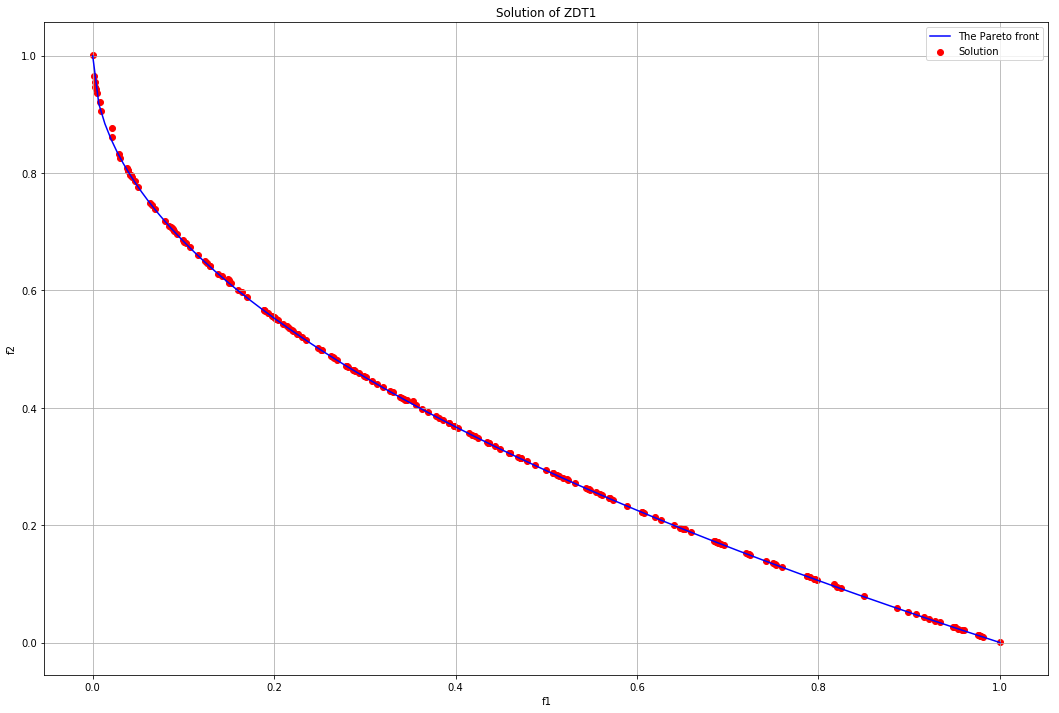

In [22]:
# The Pareto front of ZDT1.
x =  np.linspace(0, 1, 150)
y = 1 - np.sqrt(x)

fig = pyplot.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
ax.plot(x, y, color="blue", label="The Pareto front")
ax.scatter(objs[:, 0], objs[:, 1], color="red", label="Solution")
ax.set_title("Solution of ZDT1")
ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.legend()
ax.grid(True)


## The reference points

We can see a set of reference points for the problem.

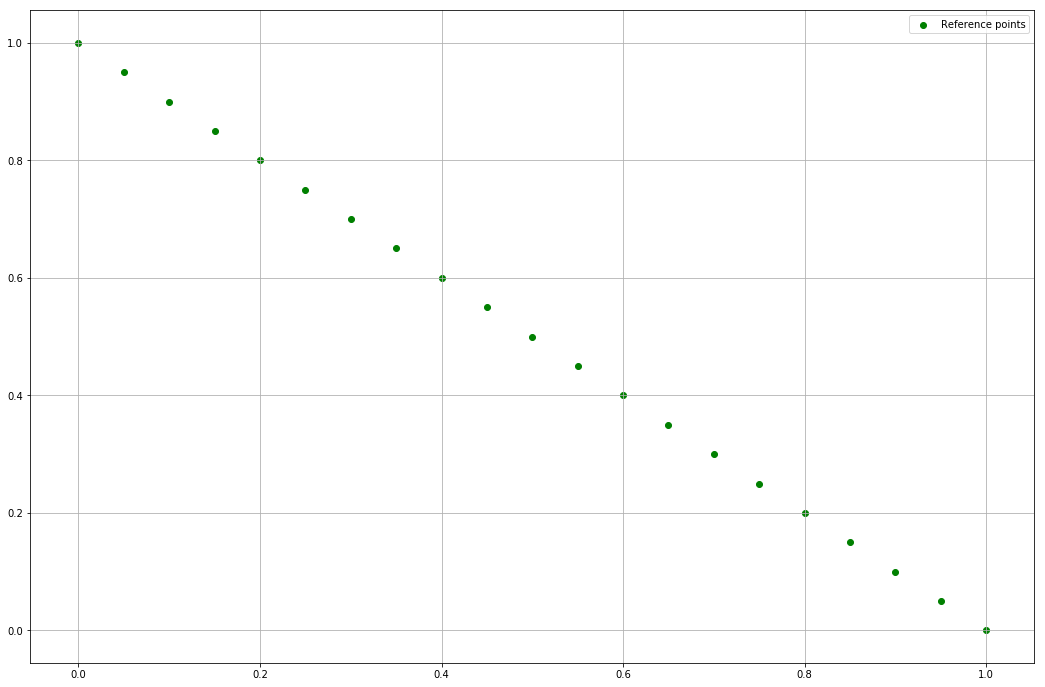

In [26]:
ref_points = np.array([ref.fitness for ref in nsga3._ref_points])

fig = pyplot.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
ax.scatter(ref_points[:, 0], ref_points[:, 1], color="green", label="Reference points")
ax.legend()
ax.grid(True)